In [39]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

%pip install mljar-supervised
from supervised.automl import AutoML

from src.data.data_fetcher import get_raw_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data, get_final_prediction
pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
# Prepare data
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,effective_radiation,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,15.2,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.53125,271.225006,872357.56250,54.224998,1.0,0.0,1014.250000,0.0,0.0,1001.700012,1007.500000,0.0,0.0,72.375000,1013.400024,92.172501,27.10800,0.00,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.645392,0.548142,1,366.725006,0,0,0
1,13.7,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.68750,5.800000,11749.87500,99.675003,1.0,0.0,1008.049988,0.0,0.0,995.549988,1001.400024,0.0,0.1,80.699997,1007.250000,236.257751,37.69725,0.10,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.004784,0.996750,1,151.325012,0,0,0
2,10.5,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.65625,65.099998,135992.90625,23.299999,1.0,0.0,1013.525024,0.0,0.0,1000.950012,1006.849976,0.0,0.0,59.049999,1012.750000,85.390503,9.44850,0.00,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.626034,0.535017,0,107.300003,0,0,0
3,6.3,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.00000,0.000000,0.00000,99.574997,0.0,1.0,999.699951,0.0,0.0,986.849976,992.949951,0.0,0.0,93.650002,999.050049,127.701752,-8.19975,0.35,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.995999,1,0.000000,0,0,0
4,6.3,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.00000,0.000000,0.00000,49.400002,0.0,1.0,1018.900024,0.0,0.0,1006.000000,1012.200012,0.0,0.0,81.649994,1018.425049,346.724243,-13.01700,0.00,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.499874,1,0.000000,0,0,0


In [41]:
# Set up and run AutoML
automl = AutoML(
    mode='Compete', 
    total_time_limit=60*20, 
    ml_task='regression',
    eval_metric='mae', 
    validation_strategy={
        "validation_type": "kfold", 
        "k_folds": 5, 
        "shuffle": True, 
        "stratify": False,
        "random_seed": 42
    }, 
    random_state=42,
    n_jobs=-1, 
    golden_features=True,
    results_path="automl",
    features_selection=True,
    stack_models=True,
)

automl.fit(x_whole, y_whole)

Linear algorithm was disabled.
AutoML directory: automl
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step simple_algorithms will try to check up to 3 models
1_DecisionTree mae 116.687883 trained in 3.73 seconds
2_DecisionTree mae 184.627634 trained in 2.36 seconds
3_DecisionTree mae 184.627634 trained in 2.34 seconds
* Step default_algorithms will try to check up to 7 models
4_Default_LightGBM mae 74.077018 trained in 325.85 seconds
* Step not_so_random will try to check up to 63 models
14_LightGBM mae 82.615086 tr

AutoML(eval_metric='mae', features_selection=True, golden_features=True,
       ml_task='regression', mode='Compete', random_state=42,
       results_path='automl', stack_models=True, total_time_limit=1200,
       validation_strategy={'k_folds': 5, 'random_seed': 42, 'shuffle': True,
                            'stratify': False, 'validation_type': 'kfold'})

In [42]:
train_prediction = automl.predict(x_whole)


test_prediction = automl.predict(X_val_est_combined)

# Evaluate the best model on the validation subset of the observed dataset
# leaderboard = automl.get_leaderboard()
# print(leaderboard)

mae_observed = mean_absolute_error(y_val_est_combined, test_prediction)

print(f'Mean Absolute Error on Validation Set: {mae_observed}')

Mean Absolute Error on Validation Set: 64.73850430106494


# Visualization

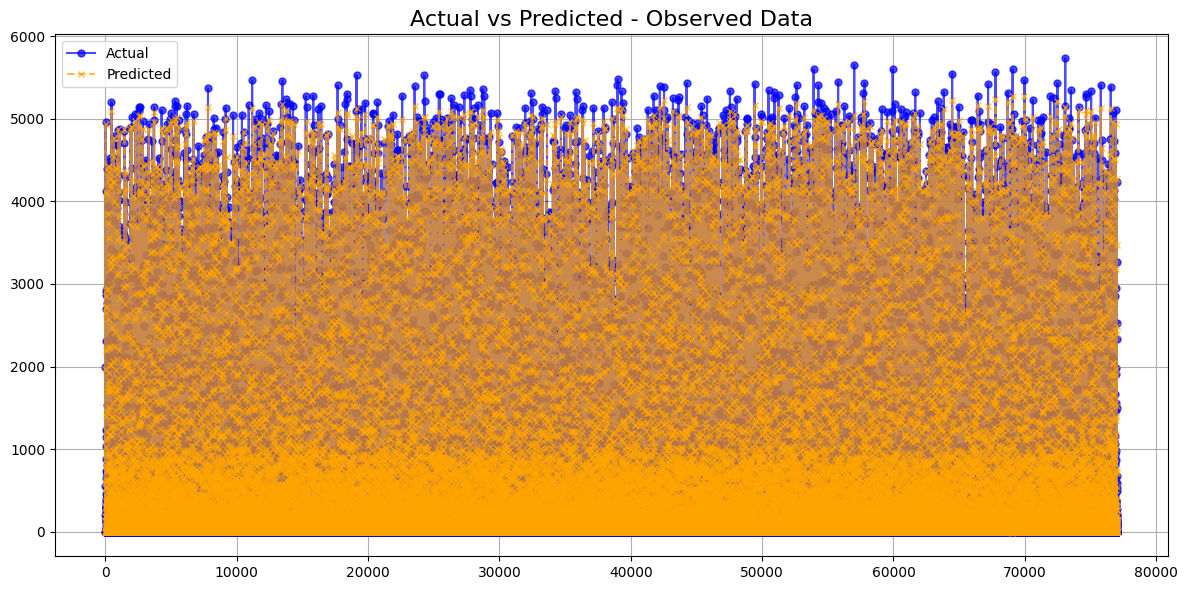

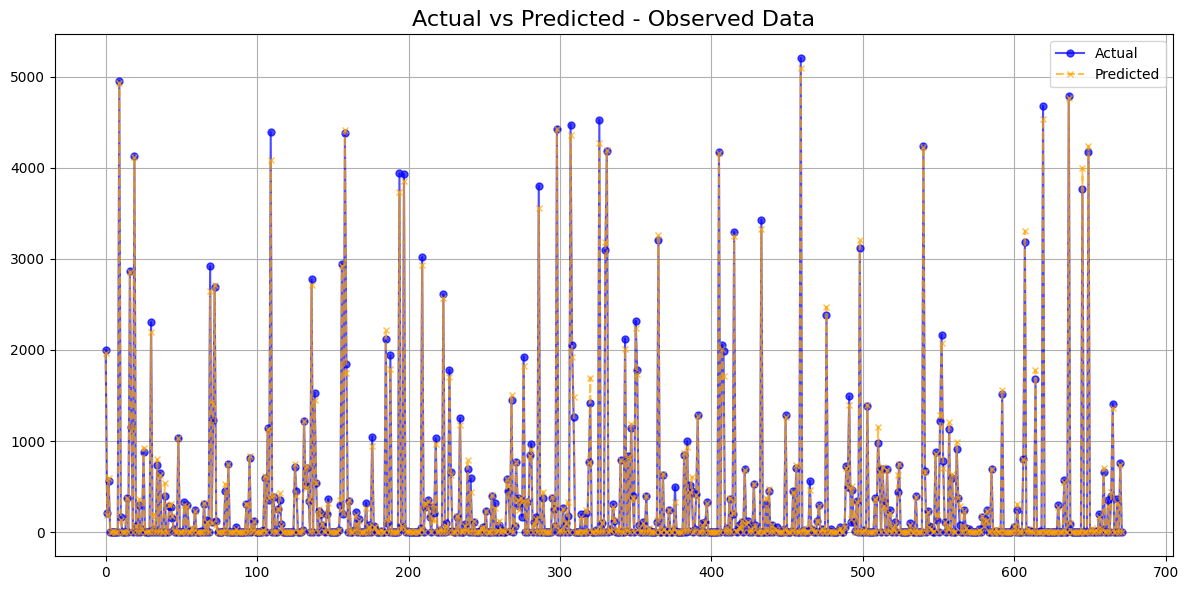

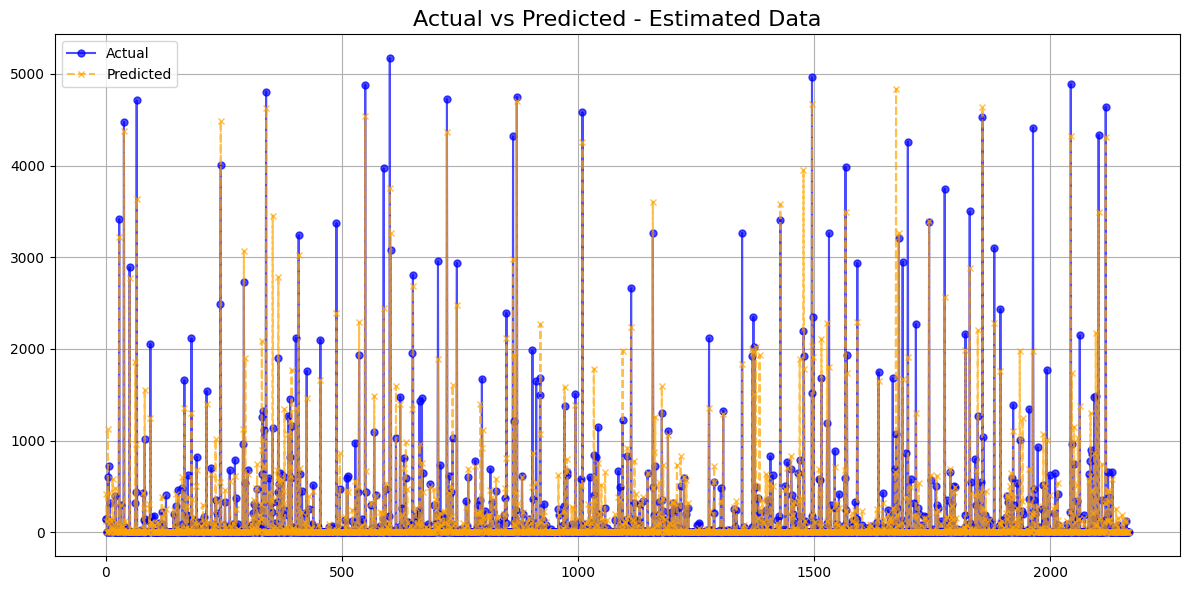

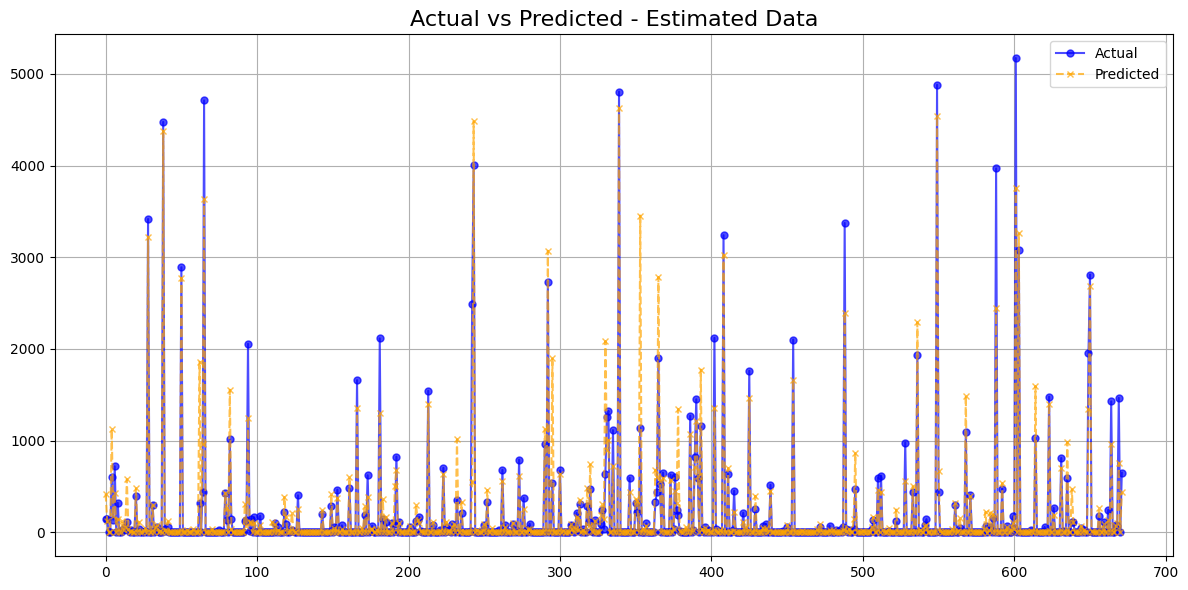

In [43]:
import matplotlib.pyplot as plt

# Observed Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualise the monthly predictions
# Observed Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimated Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualise the monthly predictions
# Estimated Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Evaluate the best model on the validation subset of the observed dataset
y_pred_a = automl.predict(X_test_estimated_a_processed)
y_pred_b = automl.predict(X_test_estimated_b_processed)
y_pred_c = automl.predict(X_test_estimated_c_processed)
# Combine the predictions
y_pred = get_final_prediction(y_pred_a, y_pred_b, y_pred_c)


In [45]:
# Save the model
from src.models.saving import save_predictions

save_predictions(y_pred, 'AutoML mljar Supervised ')

   id  prediction
0   0    0.715951
1   1    0.550388
2   2    1.078356
3   3    0.707941
4   4  181.277732
